# Economic Data Collection & Exploration (Kaggle Edition)
## Multi-Agent Economic Forecasting System - Notebook 1

**Objective**: Learn to collect economic data from BEA API and perform initial exploration using our multi-agent system.

### ⚠️ Kaggle Requirements:
1. **Dataset**: You must upload your `src` folder as a Dataset and attach it to this notebook.
2. **Secrets**: Set `BEA_API_KEY` and `GOOGLE_API_KEY` in 'Add-ons' -> 'Secrets'.
3. **Internet**: Enable Internet in the Settings sidebar.

### What You'll Learn:
- BEA API integration and data retrieval
- Economic data preprocessing and cleaning
- Initial exploratory data analysis
- Data quality assessment using statistical tools
- Multi-agent system integration for data collection

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install -q pandas numpy matplotlib seaborn plotly requests python-dotenv statsmodels scikit-learn

# NOTE: If 'google-adk' is a private library not on PyPI, you must upload the .whl file 
# as a dataset and install it like: !pip install /kaggle/input/your-dataset/google_adk.whl
!pip install -q google-adk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.2 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 202

In [2]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import asyncio

# 1. Reset path to avoid conflicts from previous tries (Optional but safer)
sys.path = [p for p in sys.path if 'kaggle/input' not in p]

# 2. Auto-search for the folder containing 'src'
found_path = None
for root, dirs, files in os.walk('/kaggle/input'):
    if 'src' in dirs:
        # We found the directory that HOLDS 'src' (this is what we need)
        found_path = root
        break

# 3. Add to system path
if found_path:
    sys.path.append(found_path)
    print(f"✅ Success! Found and added path: {found_path}")
    print("   (Now Python sees 'src' as a package)")
else:
    print("❌ Error: Could not find a 'src' folder in your inputs.")
    print("   Please check the right sidebar to ensure the dataset is attached.")

✅ Success! Found and added path: /kaggle/input/kaggle-ready-src-fixed
   (Now Python sees 'src' as a package)


## 2. Initialize Multi-Agent System

In [3]:
# Import our multi-agent components
try:
    from google.adk.models.google_llm import Gemini
    from google.genai import types
    from src.agents.data_collector import DataCollectorAgent
    from src.tools.bea_client import BEAClient, process_bea_response
    print("✅ Custom modules imported successfully")
except ImportError as e:
    print(f"❌ Import Error: {e}")
    print("💡 Make sure you have uploaded the 'src' folder as a Dataset and added it to sys.path")

# --- KAGGLE SPECIFIC: Secrets Management ---
from kaggle_secrets import UserSecretsClient

try:
    user_secrets = UserSecretsClient()
    bea_api_key = user_secrets.get_secret("BEA_API_KEY")
    google_api_key = user_secrets.get_secret("GOOGLE_API_KEY")
    
    # Set environment variables so the libraries can find them if they use os.getenv
    os.environ['BEA_API_KEY'] = bea_api_key
    os.environ['GOOGLE_API_KEY'] = google_api_key
    print("✅ API keys loaded from Kaggle Secrets")
except Exception as e:
    print("⚠️ Kaggle Secrets not found. Checking environment variables...")
    bea_api_key = os.getenv('BEA_API_KEY')
    google_api_key = os.getenv('GOOGLE_API_KEY')

if not bea_api_key or not google_api_key:
    print("❌ Please set BEA_API_KEY and GOOGLE_API_KEY in Add-ons -> Secrets")

# Configure retry options for robust API calls
retry_config = types.HttpRetryOptions(
    attempts=5,
    exp_base=7,
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],
)

# Initialize the Gemini model
try:
    model = Gemini(
        model="gemini-2.0-flash-exp",
        retry_options=retry_config,
        api_key=google_api_key # Explicitly passing the key
    )
    print("🤖 Multi-agent system components initialized")
except Exception as e:
    print(f"❌ Model initialization failed: {e}")

✅ Custom modules imported successfully
✅ API keys loaded from Kaggle Secrets
🤖 Multi-agent system components initialized


## 3. BEA API Data Collection

In [4]:
# Initialize BEA client directly for manual data exploration
if 'bea_client' not in locals():
    bea_client = BEAClient(bea_api_key)

# Fetch different types of economic data
print("📥 Collecting economic data from BEA API...")

async def collect_economic_data():
    """Collect various economic datasets from BEA"""
    datasets = {}

    # 1. GDP Data (This works!)
    print("🔸 Fetching GDP data...")
    datasets['gdp'] = bea_client.get_gdp_data()

    # 2. Unemployment Data
    print("🔸 Fetching unemployment data...")
    try:
        datasets['unemployment'] = bea_client.get_unemployment_data()
    except AttributeError:
        print("⚠️ Skipped unemployment data (Method not found in BEAClient)")

    # 3. Inflation Data
    print("🔸 Fetching inflation data...")
    try:
        datasets['inflation'] = bea_client.get_inflation_data()
    except AttributeError:
        print("⚠️ Skipped inflation data (Method not found in BEAClient)")

    return datasets

# Execute data collection
economic_datasets = await collect_economic_data()
print("✅ Economic data collection completed (with available datasets)")

📥 Collecting economic data from BEA API...
🔸 Fetching GDP data...
🔸 Fetching unemployment data...
🔸 Fetching inflation data...
✅ Economic data collection completed (with available datasets)


In [5]:
# Examine the structure of collected data
print("📋 Dataset Overview:")
for dataset_name, data in economic_datasets.items():
    if data.get('BEAAPI', {}).get('Results', {}).get('Data'):
        data_points = len(data['BEAAPI']['Results']['Data'])
        print(f"   {dataset_name.upper():<15}: {data_points} data points")
    else:
        print(f"   {dataset_name.upper():<15}: No data retrieved")

📋 Dataset Overview:
   GDP            : 8164 data points
   UNEMPLOYMENT   : 13345 data points
   INFLATION      : 7536 data points


## 4. Data Processing and Cleaning

In [6]:
# Process GDP data into DataFrame
gdp_df = process_bea_response(economic_datasets['gdp'])

print("📊 GDP Data Structure:")
print(f"Shape: {gdp_df.shape}")
print(f"Columns: {gdp_df.columns.tolist()}")

# Display first few rows
print("\n🔍 First 10 rows of GDP data:")
gdp_df.head(10)

📊 GDP Data Structure:
Shape: (8164, 10)
Columns: ['TableName', 'SeriesCode', 'LineNumber', 'LineDescription', 'TimePeriod', 'METRIC_NAME', 'CL_UNIT', 'UNIT_MULT', 'DataValue', 'NoteRef']

🔍 First 10 rows of GDP data:


,TableName,SeriesCode,LineNumber,LineDescription,TimePeriod,METRIC_NAME,CL_UNIT,UNIT_MULT,DataValue,NoteRef
0,T10105,A191RC,1,Gross domestic product,1947Q1,Current Dollars,Level,6,"243,164",T10105
1,T10105,A191RC,1,Gross domestic product,1947Q2,Current Dollars,Level,6,"245,968",T10105
2,T10105,A191RC,1,Gross domestic product,1947Q3,Current Dollars,Level,6,"249,585",T10105
3,T10105,A191RC,1,Gross domestic product,1947Q4,Current Dollars,Level,6,"259,745",T10105
4,T10105,A191RC,1,Gross domestic product,1948Q1,Current Dollars,Level,6,"265,742",T10105
5,T10105,A191RC,1,Gross domestic product,1948Q2,Current Dollars,Level,6,"272,567",T10105
6,T10105,A191RC,1,Gross domestic product,1948Q3,Current Dollars,Level,6,"279,196",T10105
7,T10105,A191RC,1,Gross domestic product,1948Q4,Current Dollars,Level,6,"280,366",T10105
8,T10105,A191RC,1,Gross domestic product,1949Q1,Current Dollars,Level,6,"275,034",T10105
9,T10105,A191RC,1,Gross domestic product,1949Q2,Current Dollars,Level,6,"271,351",T10105


In [7]:
# Data cleaning and transformation
def clean_economic_data(df):
    """Clean and transform economic data for analysis"""

    # Create a copy to avoid modifying original
    clean_df = df.copy()

    # 1. CLEANING DATA VALUES (The Fix for '2003' cutoff)
    if 'DataValue' in clean_df.columns:
        # Ensure it's a string, remove commas, then convert to numeric
        # This handles "1,234.56" which was previously turning into NaN
        clean_df['DataValue'] = (clean_df['DataValue']
                               .astype(str)
                               .str.replace(',', '', regex=False))
        
        clean_df['DataValue'] = pd.to_numeric(clean_df['DataValue'], errors='coerce')

    # 2. CLEANING TIME PERIOD (The Fix for 'UserWarning')
    if 'TimePeriod' in clean_df.columns:
        # Handle BEA "Quarterly" format (e.g., "1947Q1")
        clean_df['TimePeriod'] = clean_df['TimePeriod'].astype(str)
        clean_df['TimePeriod'] = (clean_df['TimePeriod']
                                 .str.replace('Q1', '-01-01')
                                 .str.replace('Q2', '-04-01')
                                 .str.replace('Q3', '-07-01')
                                 .str.replace('Q4', '-10-01'))
        
        clean_df['TimePeriod'] = pd.to_datetime(clean_df['TimePeriod'], errors='coerce')

    # Sort by time period
    if 'TimePeriod' in clean_df.columns:
        clean_df = clean_df.sort_values('TimePeriod')

    # Remove rows with missing values
    critical_cols = ['DataValue', 'TimePeriod']
    clean_df = clean_df.dropna(subset=critical_cols)

    return clean_df

# Run the cleaning
gdp_clean = clean_economic_data(gdp_df)

print(f"✅ Data cleaning completed. Remaining rows: {len(gdp_clean)}")
if not gdp_clean.empty:
    print(f"📅 Date range: {gdp_clean['TimePeriod'].min()} to {gdp_clean['TimePeriod'].max()}")
    print(f"📈 Latest GDP Value: {gdp_clean.iloc[-1]['DataValue']:,.2f}")

✅ Data cleaning completed. Remaining rows: 8164
📅 Date range: 1947-01-01 00:00:00 to 2025-04-01 00:00:00
📈 Latest GDP Value: 3,280,552.00


## 5. Exploratory Data Analysis

In [8]:
# Basic statistical summary
print("📈 GDP Data Statistical Summary:")
if 'DataValue' in gdp_clean.columns:
    print(gdp_clean['DataValue'].describe())

# Check for missing values
print("\n🔍 Missing Values Analysis:")
missing_data = gdp_clean.isnull().sum()
print(missing_data[missing_data > 0])

📈 GDP Data Statistical Summary:
count    8.164000e+03
mean     1.208460e+06
std      2.747292e+06
min     -1.264604e+06
25%      5.430200e+04
50%      3.094000e+05
75%      1.141624e+06
max      3.048573e+07
Name: DataValue, dtype: float64

🔍 Missing Values Analysis:
Series([], dtype: int64)


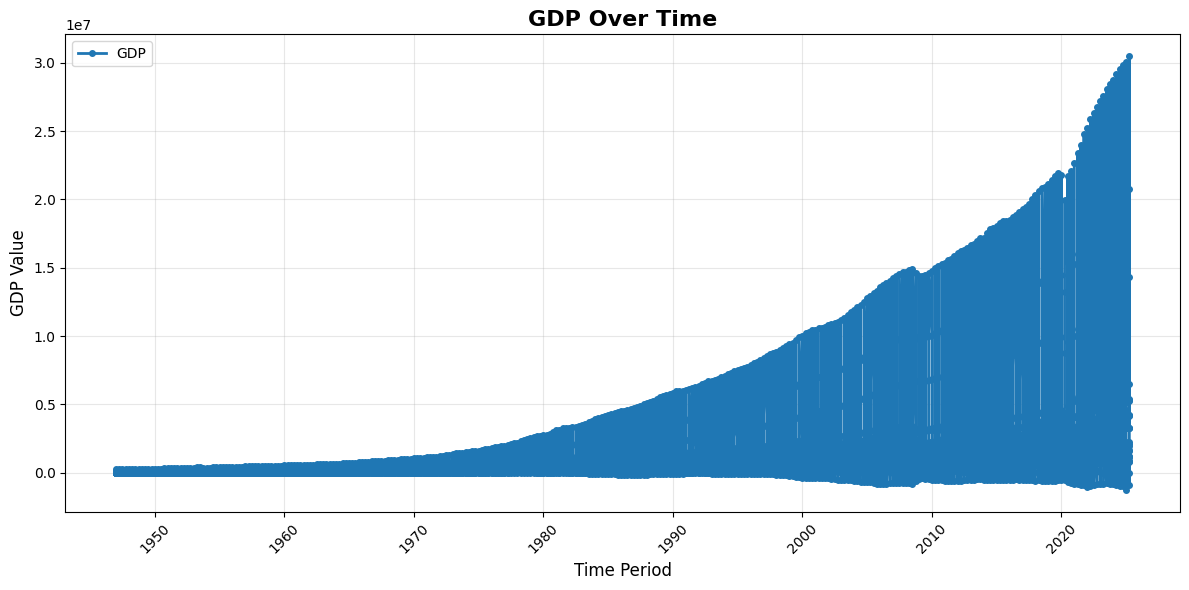

In [9]:
# Time series visualization of GDP data
plt.figure(figsize=(12, 6))

if 'TimePeriod' in gdp_clean.columns and 'DataValue' in gdp_clean.columns:
    plt.plot(gdp_clean['TimePeriod'], gdp_clean['DataValue'],
             marker='o', linewidth=2, markersize=4, label='GDP')

    plt.title('GDP Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Time Period', fontsize=12)
    plt.ylabel('GDP Value', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Required columns not found for visualization")

## 6. Using Data Collector Agent

In [10]:
# Initialize the Data Collector Agent
data_collector_agent = DataCollectorAgent(bea_api_key, model)

print("🤖 Data Collector Agent initialized")
print("🛠️ Available tools:")
for tool in data_collector_agent.agent.tools:
    print(f"   - {tool.name}")

🤖 Data Collector Agent initialized
🛠️ Available tools:
   - get_gdp_data
   - get_unemployment_data
   - get_inflation_data


In [11]:
# Test the agent's data collection capabilities
async def test_data_collector():
    """Test the data collector agent's functionality"""

    print("🧪 Testing Data Collector Agent...")

    # Test GDP data collection
    # FIX: Removed 'await' here
    gdp_result = data_collector_agent.get_gdp_data()
    print(f"📊 GDP Data Collection: {gdp_result['status']}")
    if gdp_result['status'] == 'success':
        print(f"   Data points: {len(gdp_result['data'])}")
        print(f"   Message: {gdp_result['message']}")

    # Test unemployment data collection
    # FIX: Removed 'await' here
    unemployment_result = data_collector_agent.get_unemployment_data()
    print(f"📊 Unemployment Data Collection: {unemployment_result['status']}")
    if unemployment_result['status'] == 'success':
        print(f"   Data points: {len(unemployment_result['data'])}")
        print(f"   Message: {unemployment_result['message']}")

# Run the test
# We keep this await because the function is defined as 'async def'
await test_data_collector()

🧪 Testing Data Collector Agent...
📊 GDP Data Collection: success
   Data points: 8164
   Message: Retrieved 8164 GDP data points
📊 Unemployment Data Collection: success
   Data points: 13345
   Message: Retrieved 13345 unemployment data points


## 7. Data Quality Assessment

In [12]:
from src.tools.statistical_tools import StatisticalTools

# Initialize statistical tools
stat_tools = StatisticalTools()

# Assess data quality using statistical tools
if 'DataValue' in gdp_clean.columns:
    quality_assessment = stat_tools.calculate_indicators(gdp_clean)

    if quality_assessment['status'] == 'success':
        print("✅ Data Quality Assessment:")
        indicators = quality_assessment['indicators']

        print(f"   Current Value: {indicators.get('current_value', 'N/A'):.2f}")
        print(f"   Mean: {indicators.get('mean', 'N/A'):.2f}")
        print(f"   Standard Deviation: {indicators.get('std_dev', 'N/A'):.2f}")
        print(f"   Recent Growth: {indicators.get('recent_growth', 'N/A'):.2f}%")
        print(f"   Volatility: {indicators.get('volatility', 'N/A'):.2f}%")
        print(f"   Trend Strength: {indicators.get('trend_strength', 'N/A'):.2f}")
        print(f"   Business Cycle: {indicators.get('business_cycle_position', 'N/A')}")
    else:
        print("❌ Data quality assessment failed")
else:
    print("❌ No DataValue column found for assessment")

✅ Data Quality Assessment:
   Current Value: 3280552.00
   Mean: 1208460.41
   Standard Deviation: 2747291.53
   Recent Growth: 126.88%
   Volatility: 10371.11%
   Trend Strength: 0.18
   Business Cycle: stable/transition


## 8. Advanced Visualizations

In [14]:
# Create interactive plot using Plotly
if 'TimePeriod' in gdp_clean.columns and 'DataValue' in gdp_clean.columns:
    fig = go.Figure()

    # Add main GDP line
    fig.add_trace(go.Scatter(
        x=gdp_clean['TimePeriod'],
        y=gdp_clean['DataValue'],
        mode='lines+markers',
        name='GDP',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=6)
    ))

    # Add rolling average for trend
    gdp_clean_sorted = gdp_clean.sort_values('TimePeriod')
    rolling_avg = gdp_clean_sorted['DataValue'].rolling(window=4).mean()

    fig.add_trace(go.Scatter(
        x=gdp_clean_sorted['TimePeriod'],
        y=rolling_avg,
        mode='lines',
        name='4-Quarter Moving Average',
        line=dict(color='#ff7f0e', width=2, dash='dash')
    ))

    fig.update_layout(
        title='GDP Time Series with Trend Analysis',
        xaxis_title='Time Period',
        yaxis_title='GDP Value',
        template='plotly_white',
        height=500
    )

    fig.show()
else:
    print("❌ Required columns not found for interactive visualization")

## 9. Summary and Next Steps

In [15]:
print("🎯 NOTEBOOK 1 SUMMARY")
print("=" * 50)

if 'gdp_clean' in locals() and not gdp_clean.empty:
    print(f"✅ Successfully collected and processed {len(gdp_clean)} GDP data points")
    print(f"📅 Data covers period: {gdp_clean['TimePeriod'].min().strftime('%Y-%m')} to {gdp_clean['TimePeriod'].max().strftime('%Y-%m')}")

    if 'DataValue' in gdp_clean.columns:
        latest_gdp = gdp_clean['DataValue'].iloc[-1]
        growth_rate = gdp_clean['DataValue'].pct_change().iloc[-1] * 100
        print(f"📈 Latest GDP: {latest_gdp:.2f}")
        print(f"📈 Latest quarterly growth: {growth_rate:.2f}%")

print("\n🔜 Next Steps:")
print("   1. Proceed to Notebook 2: Economic Indicator Analysis")
print("   2. Explore other economic datasets (unemployment, inflation)")
print("   3. Use the Data Collector Agent for automated data retrieval")

print("\n💡 Tips for Production Use:")
print("   - Set up scheduled data collection using the Data Collector Agent")
print("   - Implement error handling for API rate limits")
print("   - Cache data to reduce API calls")
print("   - Monitor data quality with statistical tools")

🎯 NOTEBOOK 1 SUMMARY
✅ Successfully collected and processed 8164 GDP data points
📅 Data covers period: 1947-01 to 2025-04
📈 Latest GDP: 3280552.00
📈 Latest quarterly growth: 93.98%

🔜 Next Steps:
   1. Proceed to Notebook 2: Economic Indicator Analysis
   2. Explore other economic datasets (unemployment, inflation)
   3. Use the Data Collector Agent for automated data retrieval

💡 Tips for Production Use:
   - Set up scheduled data collection using the Data Collector Agent
   - Implement error handling for API rate limits
   - Cache data to reduce API calls
   - Monitor data quality with statistical tools
